# Layout:
1. Import Packages/Libraries
2. Read Data From Previous Scrape
3. Clean + Feature Engineer Data
    + Drop Duplicates
    + Set Column Values
    + Turn Categorical Data into 0/1 Variables
    + Drop Movies
4. Split into Train and Test Set
5. EDA on Training Set
    + Pairplot
    + Correlations
6. Base Model- Patsy
7. Diagnostic Plots
8. Scale/Normalize Values
    + Log Dependent Variable
9. EDA Scaled Values
10. Regression on Logged Values
11. Lasso Regularization
**Can't Log/Polynomial Independent Variables as Needed**

12. M

# Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy import stats

import diagnostic_plots

import pickle
import time

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read Dataset from Scrape

In [33]:
df=pd.read_csv('steam3.csv')
del(df['Unnamed: 0'])
df.head()

,title,link,system,systems,reviews,release_date,discount,price
0,Warframe,https://store.steampowered.com/app/230410/Warf...,1,['win'],192592,1940,0,0.00
1,Clicker Heroes 2,https://store.steampowered.com/app/629910/Clic...,2,"['win', 'mac']",183,1,0,29.99
2,Tom Clancy's Rainbow Six® Siege,https://store.steampowered.com/app/359550/Tom_...,1,['win'],170518,959,0,14.99
3,Counter-Strike: Global Offensive,https://store.steampowered.com/app/730/Counter...,3,"['win', 'mac', 'linux']",2628652,2156,0,14.99
4,Grand Theft Auto V,https://store.steampowered.com/app/271590/Gran...,1,['win'],343780,1191,34,29.99


# Clean Data and Add Dummy Features

Remove Duplicates

In [34]:
no_dup_df = df[~df.index.duplicated(keep='first')]
no_dup_df.set_index('title', inplace=True)

Set Column Value Types

In [35]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)

## Windows, Mac, Linux -> Dummy Variables

In [36]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [37]:
no_dup_df['windows']=windows
no_dup_df['mac']=mac
no_dup_df['linux']=linux

In [38]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

## Drop Movies

In [39]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])

# Split Data into Train/Test

In [40]:
y = no_dup_df['reviews']
X = no_dup_df.drop(['reviews','link','systems'], axis = 1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

# Exploratory Data Analysis on Train Data

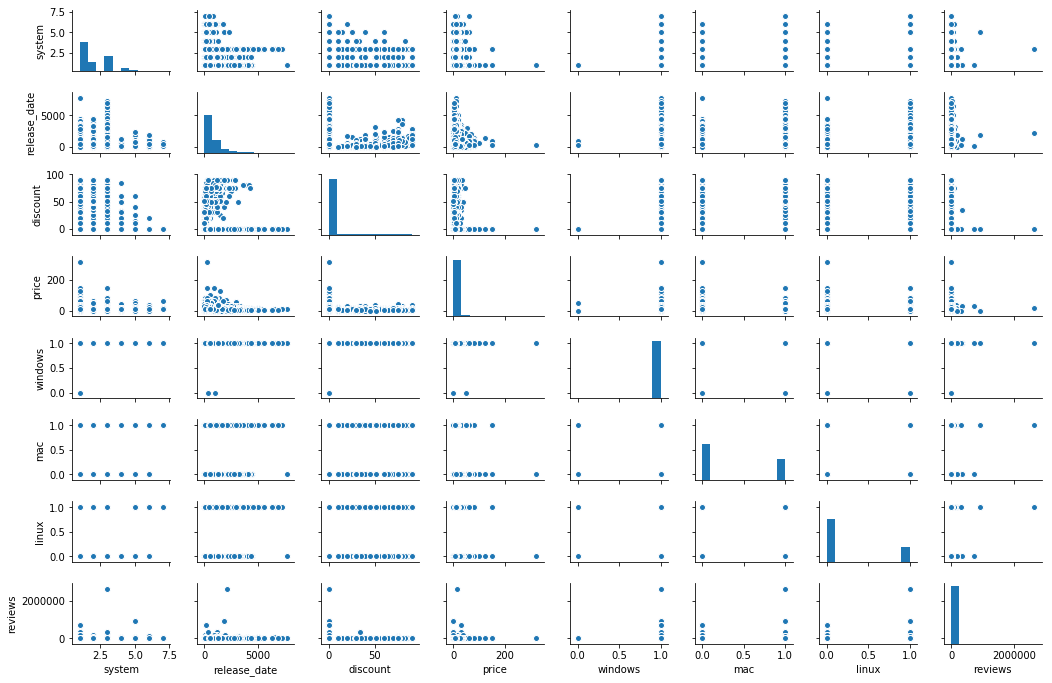

In [42]:
sns.pairplot(traindf, size = 1.2, aspect=1.5)

In [43]:
traindf.corr()
#sns.heatmap(no_dup_df.corr(), cmap="seismic")

,system,release_date,discount,price,windows,mac,linux,reviews
system,1.000000,-0.069589,-0.018282,0.016146,0.012389,0.502489,0.539572,0.033515
release_date,-0.069589,1.000000,0.001818,0.059451,0.001742,0.086093,0.064727,0.050074
discount,-0.018282,0.001818,1.000000,-0.017923,0.002747,0.010129,0.011916,0.009867
price,0.016146,0.059451,-0.017923,1.000000,-0.023021,-0.013944,-0.016945,0.041872
windows,0.012389,0.001742,0.002747,-0.023021,1.000000,-0.004056,-0.008146,0.000947
mac,0.502489,0.086093,0.010129,-0.013944,-0.004056,1.000000,0.669213,0.030120
linux,0.539572,0.064727,0.011916,-0.016945,-0.008146,0.669213,1.000000,0.040810
reviews,0.033515,0.050074,0.009867,0.041872,0.000947,0.030120,0.040810,1.000000


# Base Model

In [44]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                reviews   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.441
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           3.04e-06
Time:                        16:08:10   Log-Likelihood:                -82900.
No. Observations:                6921   AIC:                         1.658e+05
Df Residuals:                    6913   BIC:                         1.659e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6493.4065   2.73e+04     -0.238      0.812      -6e+04     4.7e+04
system         530.6058    516.060      1.028      0.304    -481.030    1542.242
release_date     2.1848      0.551      3.966      0.000       1.105       3.265
discount        14.5301     38.394      0.378      0.705     -60.735      89.795
price          127.5076     43.724      2.916      0.004      41.795     213.220
windows       4246.8863   2.73e+04      0.156      0.876   -4.92e+04    5.77e+04
mac             59.8948   1319.409      0.045      0.964   -2526.552    2646.342
linux         2559.6282   1488.514      1.720      0.086    -358.317    5477.574
==============================================================================
Omnibus:                    22051.920   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2973447904.965
Skew:                          51.322   Prob(JB):                         0.00
Kurtosis:                    3212.441   Cond. No.                     9.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Diagnostic Plots

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a11e4b840> (for post_execute):


TypeError: cannot convert the series to <class 'float'>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

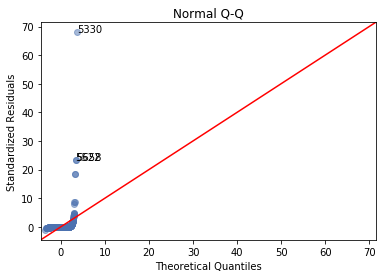

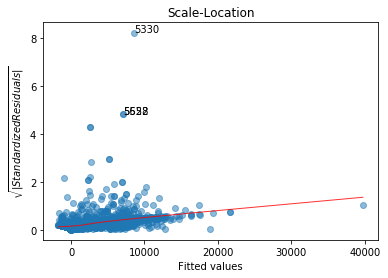

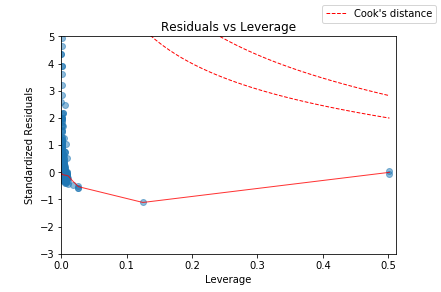

In [45]:
y_traindf=pd.DataFrame(y_train)
X_traindf=pd.DataFrame(X_train)
diagnostic_plots.diagnostic_plots(X_traindf, y_traindf, fit)

# Log Reviews/Normalize Data

(array([2863., 1153., 1941., 1499.,  987.,  544.,  268.,   61.,   16.,
           9.]),
 array([ 0.        ,  1.47819821,  2.95639642,  4.43459463,  5.91279284,
         7.39099105,  8.86918926, 10.34738747, 11.82558568, 13.3037839 ,
        14.78198211]),
 <a list of 10 Patch objects>)

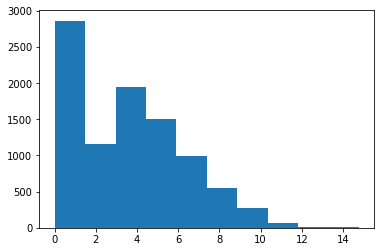

In [46]:
traindf['log_reviews'] = np.log(traindf.reviews + 1)
plt.hist(traindf['log_reviews'])

# EDA Scaled Data, Log Reviews as Dependent

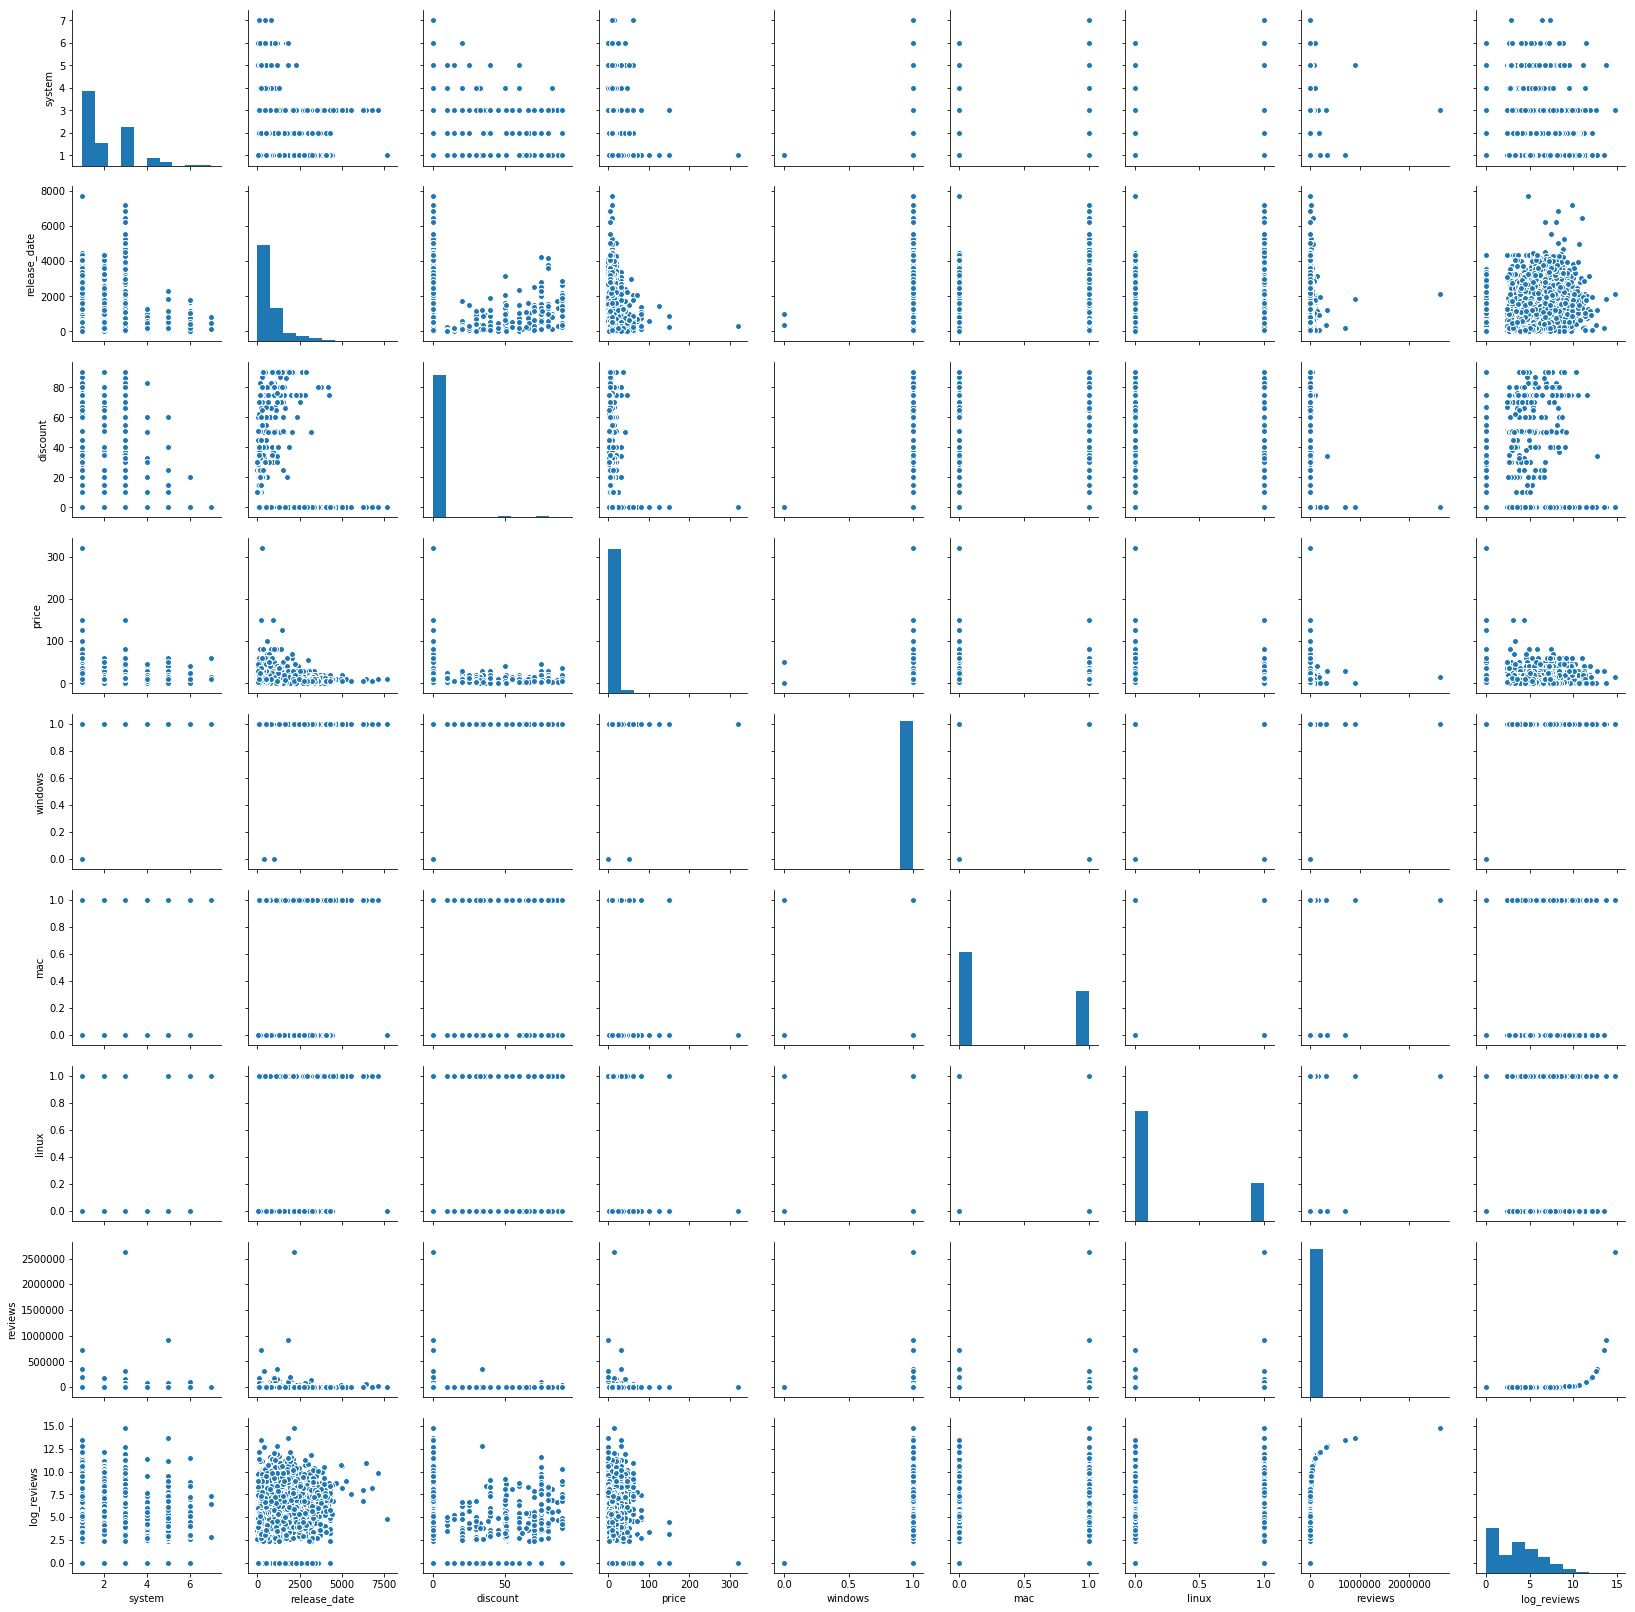

In [47]:
sns.pairplot(traindf)

In [48]:
traindf.corr()

,system,release_date,discount,price,windows,mac,linux,reviews,log_reviews
system,1.000000,-0.069589,-0.018282,0.016146,0.012389,0.502489,0.539572,0.033515,0.085932
release_date,-0.069589,1.000000,0.001818,0.059451,0.001742,0.086093,0.064727,0.050074,0.414824
discount,-0.018282,0.001818,1.000000,-0.017923,0.002747,0.010129,0.011916,0.009867,0.053296
price,0.016146,0.059451,-0.017923,1.000000,-0.023021,-0.013944,-0.016945,0.041872,0.250002
windows,0.012389,0.001742,0.002747,-0.023021,1.000000,-0.004056,-0.008146,0.000947,0.017629
mac,0.502489,0.086093,0.010129,-0.013944,-0.004056,1.000000,0.669213,0.030120,0.198312
linux,0.539572,0.064727,0.011916,-0.016945,-0.008146,0.669213,1.000000,0.040810,0.191839
reviews,0.033515,0.050074,0.009867,0.041872,0.000947,0.030120,0.040810,1.000000,0.186541
log_reviews,0.085932,0.414824,0.053296,0.250002,0.017629,0.198312,0.191839,0.186541,1.000000


# Regression on Log Values

In [49]:
y2 = traindf['log_reviews']
X2 = traindf.drop(['log_reviews'], axis = 1)
traindf=X_train.join(y_train)

model2 = sm.OLS(y2, sm.add_constant(X2))
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     461.1
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:08:31   Log-Likelihood:                -21526.
No. Observations:                9341   AIC:                         4.307e+04
Df Residuals:                    9332   BIC:                         4.313e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.0986      1.717     -1.805      0.071      -6.463       0.266
system           0.0068      0.028      0.245      0.806      -0.047       0.061
release_date     0.0013   3.13e-05     42.536      0.000       0.001       0.001
discount         0.0139      0.002      6.043      0.000       0.009       0.018
price            0.0636      0.002     25.640      0.000       0.059       0.068
windows          4.5084      1.716      2.627      0.009       1.144       7.872
mac              0.5743      0.072      7.948      0.000       0.433       0.716
linux            0.6452      0.082      7.900      0.000       0.485       0.805
reviews        1.14e-05   6.65e-07     17.127      0.000    1.01e-05    1.27e-05
==============================================================================
Omnibus:                      222.018   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              514.420
Skew:                          -0.040   Prob(JB):                    1.97e-112
Kurtosis:                       4.147   Cond. No.                     3.67e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regularize

In [ ]:
alphas = [10**x for x in range(-12, 5)]
scores = np.zeros((len(alphas),1))

In [ ]:
for j in range(len(alphas)):
    kf_score = []
    for train, test in kf:
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        std_scaler = preprocessing.StandardScaler()
        X_train_norm = std_scaler.fit_transform(X_train)
        X_test_norm = std_scaler.transform(X_test)
    
        model =  Lasso(alpha = alphas[j])
        model.fit(X_train_norm, y_train)
        y_test_predict = model.predict(X_test_norm)
        score = mean_squared_error(y_test_predict, y_test)
        kf_score.append(score)
    scores[j] = np.mean(kf_score)
print ('mse for all alpha values \n')
print (pd.DataFrame(list(zip(alphas, scores)), columns=['alpha', 'mse']))

In [ ]:
best_alpha = alphas[scores.argmin()]
print ('alpha:', best_alpha)

In [ ]:
std_scaler = preprocessing.StandardScaler()
X_norm = std_scaler.fit_transform(X)

final_model =  Lasso(alpha = best_alpha)
final_model.fit(X_norm, y)
y_predict = final_model.predict(X_norm)
final_model_score = mean_squared_error(y_predict, y)
print ('MSE:', final_model_score)

In [ ]:
df_coef = pd.DataFrame(list(zip(X.columns, final_model.coef_)), columns = ['variable', 'coefficient'])
print ('Keep')
print (df_coef[df_coef['coefficient']!=0])

In [ ]:
print ('Drop')
print (df_coef[df_coef['coefficient']==0])

# More Complicated Models